# Autoencoder Outlier Detection

## How to use the notebook

The following cells:
- specify objective, variables, and data types,
- set up the outlier detection models,
- read dataset,
- present results from the models.

To just see how it works for a toy example, simply run the whole notebook as is.

For your own project, adjust the details about objectives, variables, dataset etc. and then execute all cells in order.
The board "unsupervised.board" will help you with detailed instructions.

# Imports and General Setup

In [1]:
import os
import shutil

import numpy as np
import pandas as pd

from tensorflow import keras
from tensorflow.keras import layers

import seaborn as sns
import matplotlib.pyplot as plt

from distutils.dir_util import copy_tree

from sklearn.preprocessing import StandardScaler

from joblib import dump, load

# Project

In [2]:
experiment_name = {{cookiecutter.project_name}}  # please provide a name for the outlier detection experiment

# Dataset

In [3]:
time_series = True # Specify if the data is time series
path = '{{cookiecutter.data_path}}' # Specify the path of the data, note that it should be 'clean' without anomalies.

if path == 'default example':
    path = 'https://raw.githubusercontent.com/erium/halerium-example-data/main/outlier_detection/art_daily_small_noise.csv'

if time_series:
    df = pd.read_csv(path, parse_dates=['date'], index_col = 'date')
else:
    df = pd.read_csv(path)

num_col = len(df.columns)

path = './../out'
isExist = os.path.exists(path)
if isExist:
  for root, dirs, files in os.walk(path):
      for f in files:
          os.unlink(os.path.join(root, f))
      for d in dirs:
          shutil.rmtree(os.path.join(root, d))
else:
  os.makedirs(path)

## Visualising the dataset

In [4]:
df

,fixed acidity,volatile acidity,citric acid,residual sugar,chlorides,free sulfur dioxide,total sulfur dioxide,density,pH,sulphates,alcohol,quality,Id
0,7.4,0.700,0.00,1.9,0.076,11.0,34.0,0.99780,3.51,0.56,9.4,5,0
1,7.8,0.880,0.00,2.6,0.098,25.0,67.0,0.99680,3.20,0.68,9.8,5,1
2,7.8,0.760,0.04,2.3,0.092,15.0,54.0,0.99700,3.26,0.65,9.8,5,2
3,11.2,0.280,0.56,1.9,0.075,17.0,60.0,0.99800,3.16,0.58,9.8,6,3
4,7.4,0.700,0.00,1.9,0.076,11.0,34.0,0.99780,3.51,0.56,9.4,5,4
...,...,...,...,...,...,...,...,...,...,...,...,...,...
1138,6.3,0.510,0.13,2.3,0.076,29.0,40.0,0.99574,3.42,0.75,11.0,6,1592
1139,6.8,0.620,0.08,1.9,0.068,28.0,38.0,0.99651,3.42,0.82,9.5,6,1593
1140,6.2,0.600,0.08,2.0,0.090,32.0,44.0,0.99490,3.45,0.58,10.5,5,1594
1141,5.9,0.550,0.10,2.2,0.062,39.0,51.0,0.99512,3.52,0.76,11.2,6,1595


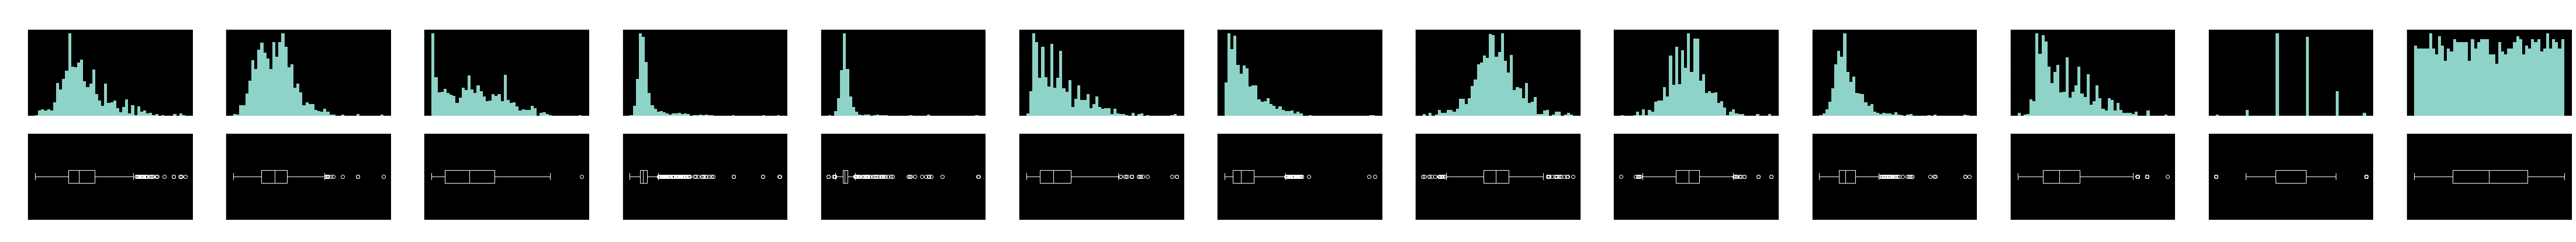

In [5]:
n_bins = 50
plt_v = 3
plt_h = 6
if time_series:
    suptitle = 'Time Series, Frequency, and Box plots of features'
    plt_row = 3
    plt_v *= 3
else:
    suptitle = 'Frequency and Box plots of features'
    plt_row = 2
    plt_v *= 2


if num_col == 1:
    fig, axs = plt.subplots(plt_row, num_col, figsize=(plt_h*num_col, plt_v))
    fig.suptitle(suptitle)
    axs[0].hist(df[df.columns[0]], bins = n_bins)
    axs[0].set_ylabel('Frequency')
    axs[1].boxplot(df[df.columns[0]], vert=False)
    axs[1].set_xlabel(df.columns[0])
    if time_series:
        axs[2].plot(df)
        axs[2].set_xlabel('time')
        axs[2].set_ylabel(df.columns[0])
elif num_col > 1:
    fig, axs = plt.subplots(plt_row, num_col, figsize=(plt_h*num_col, plt_v))
    fig.suptitle(suptitle)
    for i in range(num_col):
        axs[0][i].hist(df[df.columns[i]], bins = n_bins)
        axs[0][i].set_ylabel('Frequency')
        axs[1][i].boxplot(df[df.columns[i]], vert=False)
        axs[1][i].set_xlabel(df.columns[i])
        if time_series:
            axs[2][i].plot(df[df.columns[i]])
            axs[2][i].set_xlabel('time')
            axs[2][i].set_ylabel(df.columns[i])

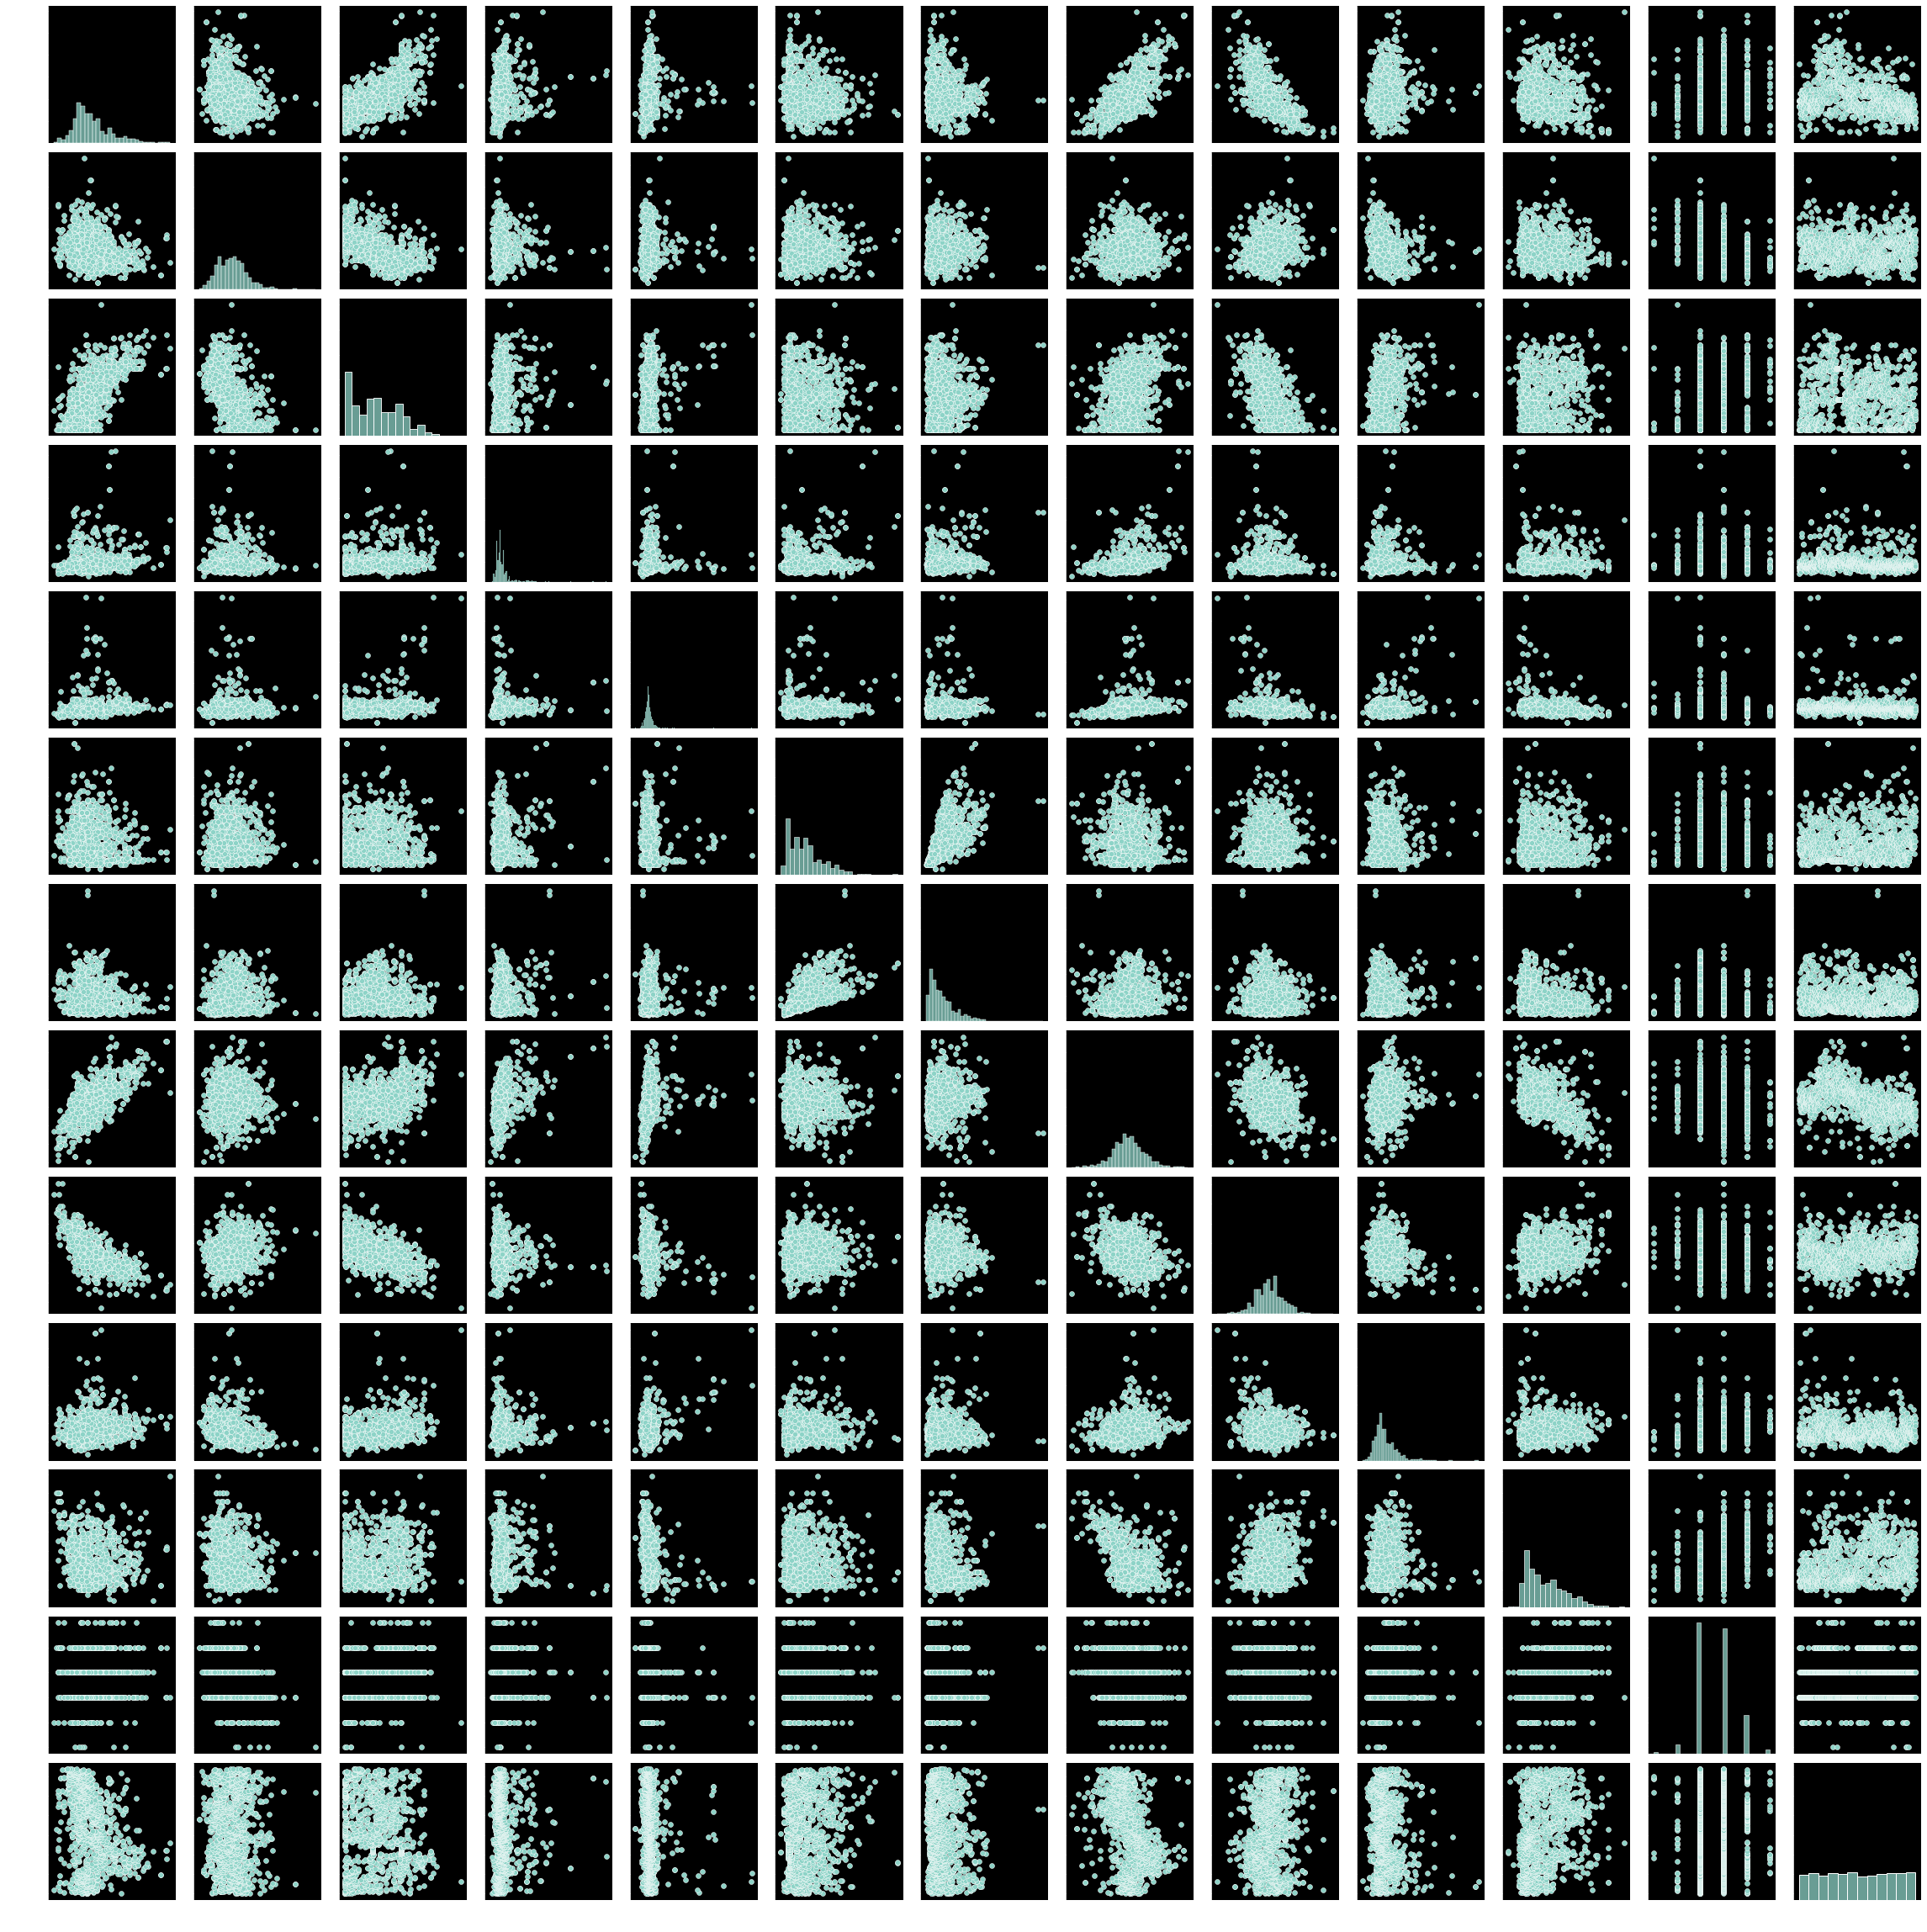

In [6]:
sns.pairplot(df)

# Normalisation

In [7]:
scaler = StandardScaler()
scaler.fit(df)
df = pd.DataFrame(scaler.transform(df), index = df.index, columns = df.columns)
df

,fixed acidity,volatile acidity,citric acid,residual sugar,chlorides,free sulfur dioxide,total sulfur dioxide,density,pH,sulphates,alcohol,quality,Id
0,-0.521580,0.939332,-1.365027,-0.466421,-0.231395,-0.450467,-0.363610,0.555854,1.270695,-0.573658,-0.963382,-0.815724,-1.735618
1,-0.292593,1.941813,-1.365027,0.050060,0.234247,0.915920,0.643477,0.036165,-0.708928,0.130881,-0.593601,-0.815724,-1.733462
2,-0.292593,1.273492,-1.161568,-0.171289,0.107253,-0.060071,0.246745,0.140103,-0.325775,-0.045254,-0.593601,-0.815724,-1.731306
3,1.653789,-1.399789,1.483400,-0.466421,-0.252560,0.135127,0.429852,0.659792,-0.964363,-0.456235,-0.593601,0.425784,-1.729150
4,-0.521580,0.939332,-1.365027,-0.466421,-0.231395,-0.450467,-0.363610,0.555854,1.270695,-0.573658,-0.963382,-0.815724,-1.726993
...,...,...,...,...,...,...,...,...,...,...,...,...,...
1138,-1.151292,-0.118842,-0.703785,-0.171289,-0.231395,1.306316,-0.180503,-0.514707,0.695966,0.541862,0.515741,0.425784,1.696940
1139,-0.865059,0.493785,-0.958109,-0.466421,-0.400719,1.208717,-0.241539,-0.114545,0.695966,0.952843,-0.870937,0.425784,1.699096
1140,-1.208538,0.382399,-0.958109,-0.392638,0.064922,1.599113,-0.058432,-0.951246,0.887542,-0.456235,0.053515,-0.815724,1.701252
1141,-1.380278,0.103932,-0.856379,-0.245072,-0.527712,2.282306,0.155192,-0.836914,1.334554,0.600574,0.700632,0.425784,1.703408


## Sequences
The autoencoder model would expect sequences as input. These sequences are groups of data and may be grouped together by a common time period (eg. Samples in a day/week/month).

In [8]:
# Use an even factor/multiple of 32
TIME_STEPS = 32 # In the example dataset, there is one data point every 5 minutes. 288 will be the timestamps in a day.

# Generated training sequences for use in the model.
def create_sequences(values, time_steps=TIME_STEPS):
    output = []
    for i in range(len(values) - time_steps + 1):
        output.append(values[i : (i + time_steps)])
    return np.stack(output)

X_train = create_sequences(df.values)
print('(Number of timestamps - time steps, time steps, num features)')
X_train.shape

(Number of timestamps - time steps, time steps, num features)


(1112, 32, 13)

In [9]:
# Convolutional Reconstruction Autoencoder
model = keras.Sequential(
    [
        layers.Input(shape=(X_train.shape[1], X_train.shape[2])),
        layers.Conv1D(
            filters=32, kernel_size=7, padding="same", strides=2, activation="relu"
        ),
        layers.Dropout(rate=0.2),
        layers.Conv1D(
            filters=16, kernel_size=7, padding="same", strides=2, activation="relu"
        ),
        layers.Conv1DTranspose(
            filters=16, kernel_size=7, padding="same", strides=2, activation="relu"
        ),
        layers.Dropout(rate=0.2),
        layers.Conv1DTranspose(
            filters=32, kernel_size=7, padding="same", strides=2, activation="relu"
        ),
        layers.Conv1DTranspose(filters=1, kernel_size=7, padding="same"),
    ]
)

model.compile(optimizer=keras.optimizers.Adam(learning_rate=0.001), loss="mse")
model.summary()

Model: "sequential"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
conv1d (Conv1D)              (None, 16, 32)            2944      
_________________________________________________________________
dropout (Dropout)            (None, 16, 32)            0         
_________________________________________________________________
conv1d_1 (Conv1D)            (None, 8, 16)             3600      
_________________________________________________________________
conv1d_transpose (Conv1DTran (None, 16, 16)            1808      
_________________________________________________________________
dropout_1 (Dropout)          (None, 16, 16)            0         
_________________________________________________________________
conv1d_transpose_1 (Conv1DTr (None, 32, 32)            3616      
_________________________________________________________________
conv1d_transpose_2 (Conv1DTr (None, 32, 1)             2

In [10]:
# LSTM for time series
if time_series:
    lstm_model = keras.Sequential()
    lstm_model.add(keras.layers.LSTM(
        units = 64,
        input_shape=(X_train.shape[1], X_train.shape[2])
        ))
    lstm_model.add(keras.layers.Dropout(rate=0.2))
    lstm_model.add(keras.layers.RepeatVector(n=X_train.shape[1]))

    lstm_model.add(keras.layers.LSTM(
        units = 64,
        return_sequences = True
        ))
    lstm_model.add(keras.layers.Dropout(rate=0.2))
    lstm_model.add(keras.layers.TimeDistributed(keras.layers.Dense(units = X_train.shape[2])))

    lstm_model.compile(optimizer=keras.optimizers.Adam(learning_rate=0.001), loss="mse")
    lstm_model.summary()

## Train the model

In [11]:
history = model.fit(
    X_train,
    X_train,
    epochs=50,
    batch_size=128,
    validation_split=0.1,
    shuffle=False, # No assumption that data is independent
    callbacks=[
        keras.callbacks.EarlyStopping(monitor="val_loss", patience=5, mode="min")
    ],
)

Epoch 1/50


1/8 [==>...........................] - ETA: 0s - loss: 1.2003

6/8 [=====================>........] - ETA: 0s - loss: 1.0283

8/8 [==============================] - 0s 42ms/step - loss: 0.9991 - val_loss: 1.0941


Epoch 2/50
1/8 [==>...........................] - ETA: 0s - loss: 1.1747

6/8 [=====================>........] - ETA: 0s - loss: 1.0155

8/8 [==============================] - 0s 13ms/step - loss: 0.9884 - val_loss: 1.0916


Epoch 3/50
1/8 [==>...........................] - ETA: 0s - loss: 1.1718

6/8 [=====================>........] - ETA: 0s - loss: 1.0120

8/8 [==============================] - 0s 13ms/step - loss: 0.9853 - val_loss: 1.0918


Epoch 4/50
1/8 [==>...........................] - ETA: 0s - loss: 1.1613

5/8 [=================>............] - ETA: 0s - loss: 1.0283

8/8 [==============================] - 0s 16ms/step - loss: 0.9823 - val_loss: 1.0910


Epoch 5/50


1/8 [==>...........................] - ETA: 0s - loss: 1.1489

5/8 [=================>............] - ETA: 0s - loss: 1.0238

8/8 [==============================] - 0s 16ms/step - loss: 0.9784 - val_loss: 1.0854


Epoch 6/50
1/8 [==>...........................] - ETA: 0s - loss: 1.1402

5/8 [=================>............] - ETA: 0s - loss: 1.0192

8/8 [==============================] - 0s 13ms/step - loss: 0.9744 - val_loss: 1.0759


Epoch 7/50
1/8 [==>...........................] - ETA: 0s - loss: 1.1349

6/8 [=====================>........] - ETA: 0s - loss: 0.9951

8/8 [==============================] - 0s 13ms/step - loss: 0.9699 - val_loss: 1.0661


Epoch 8/50
1/8 [==>...........................] - ETA: 0s - loss: 1.1272

5/8 [=================>............] - ETA: 0s - loss: 1.0096

7/8 [=========================>....] - ETA: 0s - loss: 0.9645

8/8 [==============================] - 0s 17ms/step - loss: 0.9654 - val_loss: 1.0566


Epoch 9/50
1/8 [==>...........................] - ETA: 0s - loss: 1.1264

5/8 [=================>............] - ETA: 0s - loss: 1.0067

8/8 [==============================] - 0s 15ms/step - loss: 0.9622 - val_loss: 1.0514


Epoch 10/50
1/8 [==>...........................] - ETA: 0s - loss: 1.1199

5/8 [=================>............] - ETA: 0s - loss: 1.0027

8/8 [==============================] - 0s 17ms/step - loss: 0.9584 - val_loss: 1.0445


Epoch 11/50
1/8 [==>...........................] - ETA: 0s - loss: 1.1168

6/8 [=====================>........] - ETA: 0s - loss: 0.9804

8/8 [==============================] - 0s 13ms/step - loss: 0.9555 - val_loss: 1.0411


Epoch 12/50


1/8 [==>...........................] - ETA: 0s - loss: 1.1094

6/8 [=====================>........] - ETA: 0s - loss: 0.9770

8/8 [==============================] - 0s 12ms/step - loss: 0.9523 - val_loss: 1.0362


Epoch 13/50
1/8 [==>...........................] - ETA: 0s - loss: 1.1060

6/8 [=====================>........] - ETA: 0s - loss: 0.9743

8/8 [==============================] - 0s 13ms/step - loss: 0.9495 - val_loss: 1.0311


Epoch 14/50
1/8 [==>...........................] - ETA: 0s - loss: 1.1037

6/8 [=====================>........] - ETA: 0s - loss: 0.9724

8/8 [==============================] - 0s 13ms/step - loss: 0.9478 - val_loss: 1.0287


Epoch 15/50
1/8 [==>...........................] - ETA: 0s - loss: 1.1000

6/8 [=====================>........] - ETA: 0s - loss: 0.9696

8/8 [==============================] - 0s 13ms/step - loss: 0.9451 - val_loss: 1.0267


Epoch 16/50
1/8 [==>...........................] - ETA: 0s - loss: 1.0958

6/8 [=====================>........] - ETA: 0s - loss: 0.9683

8/8 [==============================] - 0s 15ms/step - loss: 0.9437 - val_loss: 1.0212


Epoch 17/50


1/8 [==>...........................] - ETA: 0s - loss: 1.0957

6/8 [=====================>........] - ETA: 0s - loss: 0.9656

8/8 [==============================] - 0s 12ms/step - loss: 0.9417 - val_loss: 1.0199


Epoch 18/50
1/8 [==>...........................] - ETA: 0s - loss: 1.0927

6/8 [=====================>........] - ETA: 0s - loss: 0.9638

8/8 [==============================] - 0s 13ms/step - loss: 0.9397 - val_loss: 1.0195


Epoch 19/50
1/8 [==>...........................] - ETA: 0s - loss: 1.0889

6/8 [=====================>........] - ETA: 0s - loss: 0.9622

8/8 [==============================] - 0s 15ms/step - loss: 0.9381 - val_loss: 1.0142


Epoch 20/50


1/8 [==>...........................] - ETA: 0s - loss: 1.0897

4/8 [==============>...............] - ETA: 0s - loss: 1.0458

8/8 [==============================] - ETA: 0s - loss: 0.9362

8/8 [==============================] - 0s 19ms/step - loss: 0.9362 - val_loss: 1.0136


Epoch 21/50
1/8 [==>...........................] - ETA: 0s - loss: 1.0885

6/8 [=====================>........] - ETA: 0s - loss: 0.9590

8/8 [==============================] - 0s 13ms/step - loss: 0.9349 - val_loss: 1.0144


Epoch 22/50
1/8 [==>...........................] - ETA: 0s - loss: 1.0846

6/8 [=====================>........] - ETA: 0s - loss: 0.9582

8/8 [==============================] - 0s 13ms/step - loss: 0.9343 - val_loss: 1.0103


Epoch 23/50
1/8 [==>...........................] - ETA: 0s - loss: 1.0870

5/8 [=================>............] - ETA: 0s - loss: 0.9742

8/8 [==============================] - 0s 17ms/step - loss: 0.9331 - val_loss: 1.0103


Epoch 24/50
1/8 [==>...........................] - ETA: 0s - loss: 1.0847

6/8 [=====================>........] - ETA: 0s - loss: 0.9561

8/8 [==============================] - 0s 14ms/step - loss: 0.9321 - val_loss: 1.0109


Epoch 25/50
1/8 [==>...........................] - ETA: 0s - loss: 1.0812

5/8 [=================>............] - ETA: 0s - loss: 0.9725

8/8 [==============================] - 0s 16ms/step - loss: 0.9313 - val_loss: 1.0080


Epoch 26/50


1/8 [==>...........................] - ETA: 0s - loss: 1.0823

6/8 [=====================>........] - ETA: 0s - loss: 0.9539

8/8 [==============================] - 0s 14ms/step - loss: 0.9305 - val_loss: 1.0078


Epoch 27/50
1/8 [==>...........................] - ETA: 0s - loss: 1.0798

6/8 [=====================>........] - ETA: 0s - loss: 0.9532

8/8 [==============================] - 0s 13ms/step - loss: 0.9295 - val_loss: 1.0081


Epoch 28/50
1/8 [==>...........................] - ETA: 0s - loss: 1.0797

6/8 [=====================>........] - ETA: 0s - loss: 0.9526

8/8 [==============================] - 0s 13ms/step - loss: 0.9291 - val_loss: 1.0057


Epoch 29/50
1/8 [==>...........................] - ETA: 0s - loss: 1.0786

6/8 [=====================>........] - ETA: 0s - loss: 0.9512

8/8 [==============================] - 0s 13ms/step - loss: 0.9278 - val_loss: 1.0058


Epoch 30/50
1/8 [==>...........................] - ETA: 0s - loss: 1.0775

6/8 [=====================>........] - ETA: 0s - loss: 0.9513

8/8 [==============================] - 0s 13ms/step - loss: 0.9276 - val_loss: 1.0060


Epoch 31/50
1/8 [==>...........................] - ETA: 0s - loss: 1.0768

6/8 [=====================>........] - ETA: 0s - loss: 0.9506

8/8 [==============================] - 0s 12ms/step - loss: 0.9270 - val_loss: 1.0038


Epoch 32/50
1/8 [==>...........................] - ETA: 0s - loss: 1.0779

6/8 [=====================>........] - ETA: 0s - loss: 0.9501

8/8 [==============================] - 0s 14ms/step - loss: 0.9266 - val_loss: 1.0040


Epoch 33/50
1/8 [==>...........................] - ETA: 0s - loss: 1.0754

6/8 [=====================>........] - ETA: 0s - loss: 0.9496

8/8 [==============================] - 0s 13ms/step - loss: 0.9259 - val_loss: 1.0050


Epoch 34/50
1/8 [==>...........................] - ETA: 0s - loss: 1.0759

6/8 [=====================>........] - ETA: 0s - loss: 0.9497

8/8 [==============================] - 0s 12ms/step - loss: 0.9261 - val_loss: 1.0029


Epoch 35/50
1/8 [==>...........................] - ETA: 0s - loss: 1.0753

5/8 [=================>............] - ETA: 0s - loss: 0.9662

8/8 [==============================] - 0s 15ms/step - loss: 0.9254 - val_loss: 1.0027


Epoch 36/50
1/8 [==>...........................] - ETA: 0s - loss: 1.0746

5/8 [=================>............] - ETA: 0s - loss: 0.9660

8/8 [==============================] - ETA: 0s - loss: 0.9255

8/8 [==============================] - 0s 18ms/step - loss: 0.9255 - val_loss: 1.0037


Epoch 37/50
1/8 [==>...........................] - ETA: 0s - loss: 1.0731

5/8 [=================>............] - ETA: 0s - loss: 0.9649

8/8 [==============================] - 0s 14ms/step - loss: 0.9250 - val_loss: 1.0024


Epoch 38/50
1/8 [==>...........................] - ETA: 0s - loss: 1.0748

6/8 [=====================>........] - ETA: 0s - loss: 0.9486

8/8 [==============================] - 0s 13ms/step - loss: 0.9248 - val_loss: 1.0012


Epoch 39/50
1/8 [==>...........................] - ETA: 0s - loss: 1.0732

5/8 [=================>............] - ETA: 0s - loss: 0.9644

7/8 [=========================>....] - ETA: 0s - loss: 0.9236

8/8 [==============================] - 0s 18ms/step - loss: 0.9240 - val_loss: 1.0032


Epoch 40/50
1/8 [==>...........................] - ETA: 0s - loss: 1.0733

5/8 [=================>............] - ETA: 0s - loss: 0.9644

8/8 [==============================] - 0s 18ms/step - loss: 0.9242 - val_loss: 1.0008


Epoch 41/50


1/8 [==>...........................] - ETA: 0s - loss: 1.0734

5/8 [=================>............] - ETA: 0s - loss: 0.9644

8/8 [==============================] - 0s 15ms/step - loss: 0.9235 - val_loss: 1.0007


Epoch 42/50
1/8 [==>...........................] - ETA: 0s - loss: 1.0721

6/8 [=====================>........] - ETA: 0s - loss: 0.9467

8/8 [==============================] - 0s 13ms/step - loss: 0.9234 - val_loss: 1.0018


Epoch 43/50
1/8 [==>...........................] - ETA: 0s - loss: 1.0706

6/8 [=====================>........] - ETA: 0s - loss: 0.9461

8/8 [==============================] - 0s 13ms/step - loss: 0.9228 - val_loss: 1.0001


Epoch 44/50
1/8 [==>...........................] - ETA: 0s - loss: 1.0720

6/8 [=====================>........] - ETA: 0s - loss: 0.9466

8/8 [==============================] - 0s 13ms/step - loss: 0.9229 - val_loss: 0.9995


Epoch 45/50
1/8 [==>...........................] - ETA: 0s - loss: 1.0715

6/8 [=====================>........] - ETA: 0s - loss: 0.9462

8/8 [==============================] - 0s 13ms/step - loss: 0.9227 - val_loss: 1.0010


Epoch 46/50
1/8 [==>...........................] - ETA: 0s - loss: 1.0704

6/8 [=====================>........] - ETA: 0s - loss: 0.9458

8/8 [==============================] - 0s 12ms/step - loss: 0.9226 - val_loss: 0.9995


Epoch 47/50
1/8 [==>...........................] - ETA: 0s - loss: 1.0700

6/8 [=====================>........] - ETA: 0s - loss: 0.9456

8/8 [==============================] - 0s 14ms/step - loss: 0.9222 - val_loss: 0.9990


Epoch 48/50
1/8 [==>...........................] - ETA: 0s - loss: 1.0699

6/8 [=====================>........] - ETA: 0s - loss: 0.9451

8/8 [==============================] - 0s 13ms/step - loss: 0.9217 - val_loss: 1.0001


Epoch 49/50
1/8 [==>...........................] - ETA: 0s - loss: 1.0700

6/8 [=====================>........] - ETA: 0s - loss: 0.9452

8/8 [==============================] - 0s 13ms/step - loss: 0.9218 - val_loss: 0.9983


Epoch 50/50
1/8 [==>...........................] - ETA: 0s - loss: 1.0698

6/8 [=====================>........] - ETA: 0s - loss: 0.9450

8/8 [==============================] - 0s 15ms/step - loss: 0.9217 - val_loss: 0.9985


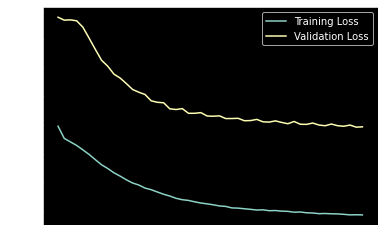

In [12]:
plt.plot(history.history["loss"], label="Training Loss")
plt.plot(history.history["val_loss"], label="Validation Loss")
plt.legend()
plt.show()

In [13]:
if time_series:
    lstm_history = lstm_model.fit(
        X_train,
        X_train,
        epochs=50,
        batch_size=128,
        validation_split=0.1,
        shuffle=False, # No assumption that data is independent
        callbacks=[
            keras.callbacks.EarlyStopping(monitor="val_loss", patience=5, mode="min")
        ],
    )

In [14]:
if time_series:
    plt.plot(lstm_history.history["loss"], label="Training Loss")
    plt.plot(lstm_history.history["val_loss"], label="Validation Loss")
    plt.legend()
    plt.show()

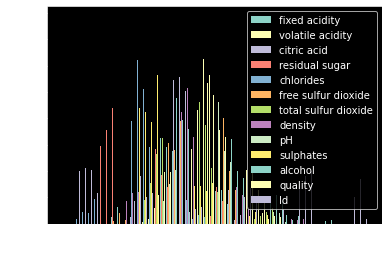

Reconstruction error threshold:  [1.44088787 1.1926531  1.2054649  1.19848573 0.90908293 1.06939551
 1.2091795  1.29700309 1.17997576 1.18305111 1.29829511 1.30471725
 1.59693629]


In [15]:
# Get train MAE loss.
X_train_pred = model.predict(X_train)
train_mae_loss = np.mean(np.abs(X_train_pred - X_train), axis=1)

plt.hist(train_mae_loss, bins=50)
plt.xlabel("Train MAE loss")
plt.ylabel("No of samples")
plt.legend(labels = df.columns)
plt.show()

# Get reconstruction loss threshold.
threshold = np.amax(train_mae_loss, axis=0)
print("Reconstruction error threshold: ", threshold)

In [16]:
if time_series:
    # Get train MAE loss from LSTM model.
    lstm_X_train_pred = lstm_model.predict(X_train)
    lstm_train_mae_loss = np.mean(np.abs(lstm_X_train_pred - X_train), axis=1)

    plt.hist(lstm_train_mae_loss, bins=50)
    plt.xlabel("Train MAE loss")
    plt.ylabel("No of samples")
    plt.legend(labels = df.columns)
    plt.show()

    # Get reconstruction loss threshold.
    lstm_threshold = np.amax(lstm_train_mae_loss, axis=0)
    print("Reconstruction error threshold: ", lstm_threshold)

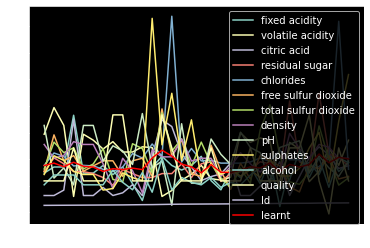

In [17]:
# Check how the first sequence is learnt
plt.plot(X_train[0], label=df.columns)
plt.plot(X_train_pred[0], color='r', label='learnt')
plt.legend()
plt.show()

In [18]:
if time_series:
    plt.plot(X_train[0], label=df.columns)
    plt.plot(lstm_X_train_pred[0], label=['learnt ' + col for col in df.columns])
    plt.legend()
    plt.show()

## Export the data
Picking the model with the lower total mae loss

In [21]:
if time_series:
    if len(df.columns) > 1:
        sum_mae_loss = sum(sum(train_mae_loss))
        lstm_sum_mae_loss = sum(sum(lstm_train_mae_loss))
    else:
        sum_mae_loss = sum(train_mae_loss)
        lstm_sum_mae_loss = sum(lstm_train_mae_loss)
    print(sum_mae_loss)
    print(lstm_sum_mae_loss)
else:
    print(sum_mae_loss)
if time_series and lstm_sum_mae_loss < sum_mae_loss:
    lstm_model.save('./../out/autoencoder_model')
    dump([[scaler, TIME_STEPS, lstm_threshold], scaler.inverse_transform(df), time_series], './../out/autoencoder_model_data.joblib')
else:
    model.save('./../out/autoencoder_model')
    dump([[scaler, TIME_STEPS, threshold], scaler.inverse_transform(df), time_series], './../out/autoencoder_model_data.joblib')

10380.107501660932


Instructions for updating:
This property should not be used in TensorFlow 2.0, as updates are applied automatically.


Instructions for updating:
This property should not be used in TensorFlow 2.0, as updates are applied automatically.


INFO:tensorflow:Assets written to: ./../out/autoencoder_model/assets
